In [148]:
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_score
from sklearn import cross_validation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

In [149]:
col_names = ['Pregnancy_Count','Glucone_conc','Blood_pressure','Skin_thickness','Insulin','BMI','DPF','Age','Class']
data = pd.read_csv('./Diabetes.tsv', skiprows=9, names=col_names)
data.head()

,Pregnancy_Count,Glucone_conc,Blood_pressure,Skin_thickness,Insulin,BMI,DPF,Age,Class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


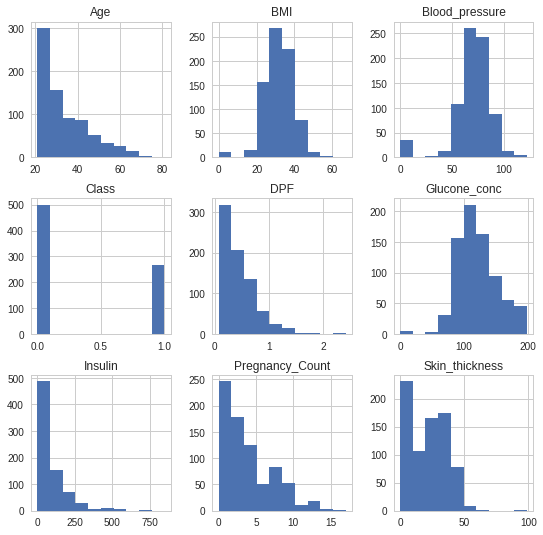

In [150]:
fig = data.hist(figsize=(9,9))

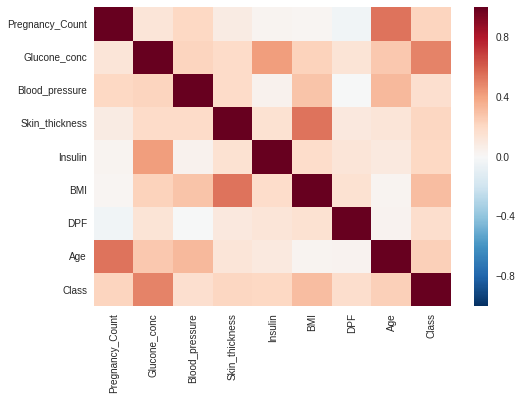

In [120]:
# Check if there are any correlations between the features. 
sns.heatmap(data.corr())

In [25]:
data.describe()

,Pregnancy_Count,Glucone_conc,Blood_pressure,Skin_thickness,Insulin,BMI,DPF,Age,Class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [42]:
### DATA PREPROCESSING ###

# Step 1 :  Check for missing data or invalid values.
data.isnull().sum()

Pregnancy_Count    0
Glucone_conc       0
Blood_pressure     0
Skin_thickness     0
Insulin            0
BMI                0
DPF                0
Age                0
Class              0
dtype: int64

In [75]:
# There are no missing values. 
# However, the following coloumns have an invalid zero value :
# ---> Glucose Conc, Blood Pressure, Skin Thickness, Insulin, BMI 

# mark zero values as missing or NaN
data.iloc[:,1:6] = data.iloc[:,1:6].replace(0, np.NaN)

# Drop row if more than 2 values are missing.
data.dropna(thresh=2, axis=0, inplace=True)

# Replace np.nan with median value. 
imputer = Imputer(missing_values = np.NAN, strategy = 'median', axis = 0)
imputer = imputer.fit(data.iloc[:,1:6])
data.iloc[:,1:6] = imputer.transform(data.iloc[:,1:6])

In [76]:
data.shape

(768, 9)

In [70]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [127]:
## MODEL SELECTION
## Evaluating the performance of various models using default parameters. 
## Contenders for the best classifier : K-Nearest Neighbors, Support Vector Classifier, 
## Logistic Regression, Gaussian Naive Bayes, Random Forest and Gradient Boost 

# Evaluation method 1 : Train/Test Split

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 5)

# Scaling features
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

models = []

models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC_lnr', SVC(kernel='linear')))
models.append(('SVC_rbf', SVC(kernel='rbf')))
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))

names = []
scores = []

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
    names.append(name)
    
tr_split = pd.DataFrame({'Name': names, 'Score': scores})
print(tr_split)

      Name     Score
0      KNN  0.709957
1  SVC_lnr  0.748918
2  SVC_rbf  0.761905
3       LR  0.761905
4       DT  0.692641
5      GNB  0.748918
6       RF  0.744589
7       GB  0.753247


In [110]:
# Evaluation method 2 : K-fold Cross Validation 
# More accurate than the test-train split method.

names_cv = []
scores_cv = []

for name, model in models:
    classifier_pipeline = make_pipeline(StandardScaler(), model)
    scores = cross_validation.cross_val_score(classifier_pipeline, X, y, cv=5)
    scores_cv.append(scores.mean())
    names_cv.append(name)
    
cv = pd.DataFrame({'Name': names_cv, 'Mean_Score': scores_cv})
print(cv)

   Mean_Score     Name
0    0.735719      KNN
1    0.765648  SVC_lnr
2    0.752670  SVC_rbf
3    0.770868       LR
4    0.704558       DT
5    0.750047      GNB
6    0.739674       RF
7    0.765631       GB


In [92]:
# SVM and logistic regression perform the best.
# Let's tune the parameters to improve the model performance. 

from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
grid = GridSearchCV(LogisticRegression(), param_grid)
grid.fit(X, y)

# summarize the results of the grid search
print("Best score: %0.2f%%" % (100*grid.best_score_))
print("Best estimator for parameter C: %f" % (grid.best_estimator_.C))

Best score: 76.82%
Best estimator for parameter C: 1000.000000


In [94]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'kernel':['linear','rbf']}

grid = GridSearchCV(SVC(), param_grid)
grid.fit(X, y)

# summarize the results of the grid search
print("Best score: %0.2f" % (100*grid.best_score_))
print("Best estimator for parameter C: %f" % (grid.best_estimator_.C))

Best score: 76.69%
Best estimator for parameter C: 1000.000000


In [142]:
# Makinf final model using Logistic regression using the optimized parameters.

classifier_pipeline = make_pipeline(StandardScaler(), LogisticRegression(C=1000))
scores_final = cross_val_score(classifier_pipeline, X, y, cv=5).mean()
print("The accuracy of the Final Logistic Regression model is %0.2f" %(100*scores_final))

The accuracy of the Final Logistic Regression model is 77.09


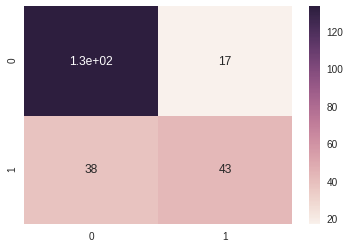

In [143]:
# Confusion Matrix

clf.fit(X_train,y_train)
Conf=confusion_matrix(y_test,clf.predict(X_test))
cm_fig = sns.heatmap(Conf,annot=True)

In [147]:
print ("\nClassification Report : \n")
print(classification_report(y_test, clf.predict(X_test)))


Classification Report : 

             precision    recall  f1-score   support

          0       0.78      0.89      0.83       150
          1       0.72      0.53      0.61        81

avg / total       0.76      0.76      0.75       231



In [134]:
y_pred_quant = clf.predict_proba(X_test)[:, 1] #Only keep the first column, which is the 'pos' values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

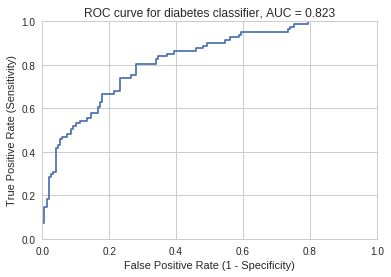

In [151]:
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
fig_title = ("ROC curve for diabetes classifier, AUC = %0.3f" %(auc(fpr,tpr)))
plt.title(fig_title)
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)